In [27]:
#Competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
import numpy as np
import pandas as pd
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
train_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

train_data, test_data = train_test_split(train_data, test_size=0.1)

train_data=train_data.set_index(train_data['Id'])
test_data=test_data.set_index(test_data['Id'])

train_data[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1226,1226,80,RL,65.0,10482,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnWw,NaN,0,6,2007,WD,Normal,145000
802,802,30,RM,40.0,4800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,109900
967,967,50,RL,130.0,9600,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,160000
1085,1085,60,RL,NaN,13031,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,187500
398,398,60,RL,69.0,7590,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,169500


Numerical columns:
- LotFrontage
- LotArea
- YearBuilt TODO create age from this.
- YearRemodAdd TODO create age from this.

Ignored:
- LandContour, LandSlope, Exterior2nd, 

I stopped at MasVnrArea
    

In [3]:
# Clean data.
train_data['Alley'].fillna('-1', inplace=True)
train_data['MasVnrType'].fillna('-1', inplace=True)
test_data['Alley'].fillna('-1', inplace=True)
test_data['MasVnrType'].fillna('-1', inplace=True)

# To check group-by count
#train_data['LotShape'].groupby(train_data['LotShape']).count()

In [6]:
categorical_columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LotConfig', 'Neighborhood',
    'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'MasVnrType']

def prepare_train(X):
    train_X = pd.DataFrame(X[[]], index=X.index)
    
    transformers=[]    
    for column in categorical_columns:  
        enc = OneHotEncoder(handle_unknown = 'ignore')
        train_X = train_X.join( 
            pd.DataFrame(
                data=enc.fit_transform(X[[column]]).toarray(), index=X.index, 
                columns=enc.get_feature_names()),
            rsuffix='_'+column
        )
        transformers.append(enc)

    return train_X, transformers

def prepare_test(X, transformers):
    test_X = pd.DataFrame(X[[]], index=X.index)
    
    for column, enc in zip(categorical_columns, transformers):
        test_X = test_X.join( 
            pd.DataFrame(data=enc.transform(X[[column]]).toarray(), index=X.index,
                         columns=enc.get_feature_names()),
            rsuffix='_'+column
        )
    return test_X

X_train, transformers = prepare_train(train_data)
X_test = prepare_test(test_data, transformers)

Y_train = train_data['SalePrice']
Y_test = test_data['SalePrice']

X_train[:3]

,x0_20,x0_30,x0_40,x0_45,x0_50,x0_60,x0_70,x0_75,x0_80,x0_85,...,x0_Stone,x0_Stucco,x0_VinylSd,x0_Wd Sdng,x0_WdShing,x0_-1_MasVnrType,x0_BrkCmn,x0_BrkFace_MasVnrType,x0_None,x0_Stone_MasVnrType
Id,,,,,,,,,,,,,,,,,,,,,
1226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
802,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
967,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


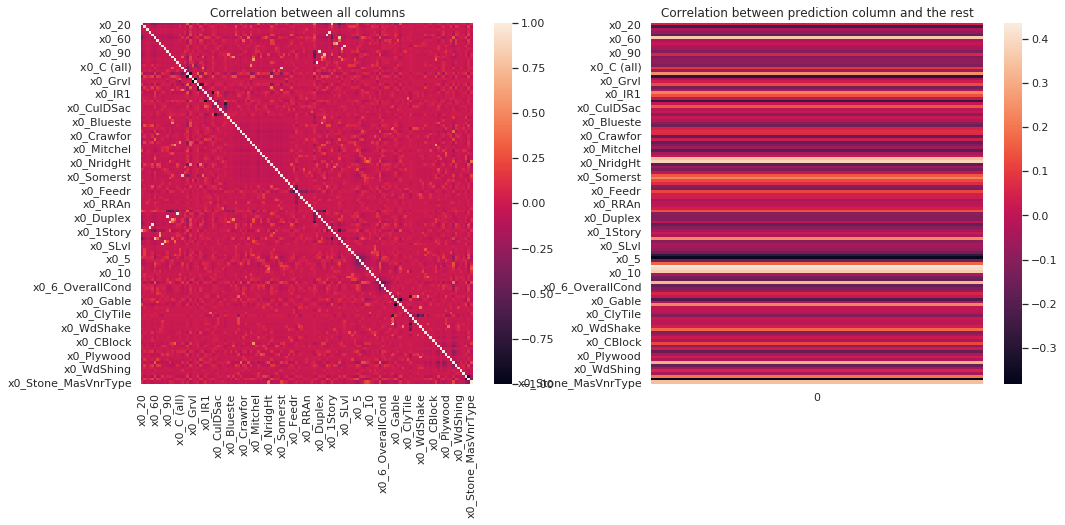

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
fig.tight_layout(pad=5) 

ax1.title.set_text('Correlation between all columns')
sns.heatmap(X_train.corr(), ax=ax1)

ax2.title.set_text('Correlation between prediction column and the rest')
sns.heatmap(X_train.corrwith(train_data['SalePrice']).to_frame(), ax=ax2)
plt.show()

# Colors different than 0 means there is correlation between SalePrice and the columns used to predict them
# Mostly red in "Correlation between all columns" means that there is little correlation between
# the columns, which means that they carry unique information 

In [14]:
def train(X_train, Y_train, design):
    model = MLPClassifier(solver='sgd', hidden_layer_sizes=design, max_iter=10, verbose=10,
                          #learning_rate='adaptive', 
                          learning_rate_init=0.1
                         )
    model.fit(X_train, Y_train)
    return model 

model = train(X_train, Y_train, design=(50))
train_acc=model.score(X_train, Y_train)
print('train_acc={}, '.format(str(train_acc)))

test_acc=model.score(X_test, Y_test)
print('test_acc={}, '.format(str(test_acc)))

Iteration 1, loss = 6.43951182
Iteration 2, loss = 6.40530828
Iteration 3, loss = 6.35491472
Iteration 4, loss = 6.27305715
Iteration 5, loss = 6.15925224
Iteration 6, loss = 6.08323811
Iteration 7, loss = 6.03229432
Iteration 8, loss = 5.98822512
Iteration 9, loss = 5.94164500
Iteration 10, loss = 5.89197574
Iteration 11, loss = 5.83548602
Iteration 12, loss = 5.77510197
Iteration 13, loss = 5.71134821
Iteration 14, loss = 5.64603752
Iteration 15, loss = 5.57920412
Iteration 16, loss = 5.51228834
Iteration 17, loss = 5.44356516
Iteration 18, loss = 5.37571925
Iteration 19, loss = 5.30531035
Iteration 20, loss = 5.22873675
Iteration 21, loss = 5.15059295
Iteration 22, loss = 5.07377102
Iteration 23, loss = 4.99006001
Iteration 24, loss = 4.90065376
Iteration 25, loss = 4.81757376
Iteration 26, loss = 4.72309580
Iteration 27, loss = 4.63390594
Iteration 28, loss = 4.54433402
Iteration 29, loss = 4.44492260
Iteration 30, loss = 4.34672124
Iteration 31, loss = 4.25525141
Iteration 32, los

/home/gpachitariu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
